![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Joe |
<b>Student-nr</b>: KD6-3.7 |
<b>Date</b>: July 1, 2049
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition is mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. The face match process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors that can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * 1. Read caltech dataset
    * 2. Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * 1. Detect faces
    * 2. Print statistics of data
    * 3. Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * 1. Eigenfaces for face recognition
    * 2. Fisherfaces for face recognition
    * 3. LBP for face recognition
    * 4. Deep metric learning
        * 4.1 Deep Metric Learning using Siamese Networks
        
* [IV. Classification in typical biometrics setting](#IV.-Classification-in-typical-biometrics-setting)
* [V. Advanced classification scenario](#V.-Advanced-classification-scenario)
* [VI. Evaluation](#VI.-Evaluation)
    * 1. Validation as verification system
    * 2. Validation as identification system
    * 3. Validation in multi-classification setting
    
* [VII. Task](#VII.-Task)
    * 1. Mandatory tasks
    * 2. Tasks of choice

**Note: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [1]:
!pip install intersect
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, auc, det_curve
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from itertools import product
from intersect import intersection

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [2]:
# size of each face after preprocessing
face_size=(47, 47)

In [3]:
import pandas as pd

k_list = []

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    k_list.append(k)

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully (5 images were removed from the original set)
assert len(data['images']) == len(data['target']) == 445

### 2. Inspect some images

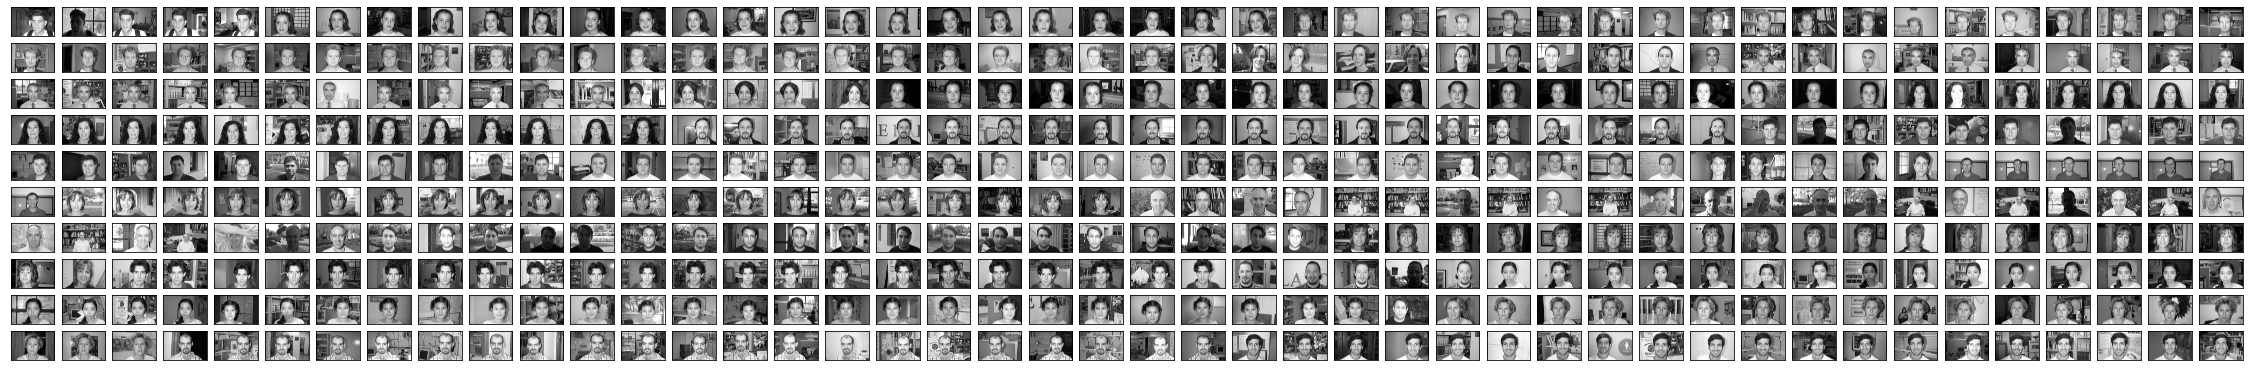

In [4]:
fig = plt.figure(figsize=(40, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 44), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods. Please study the relevant publications on these detectors to understand their functioning.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html).

In [5]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [6]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

### 2. Print statistics of data

In [7]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

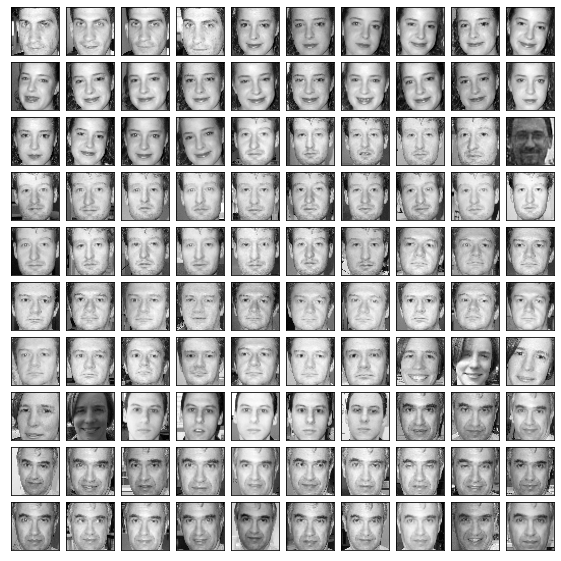

In [8]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [9]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. ([Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images (presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [10]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded = X_pca
    
    dist_metric = euclidean

### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is [Linear Discriminant Analysis (LDA)](http://www.scholarpedia.org/article/Linear_Discriminant_Analysis), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes-1, n_features))
    print('num_components:', num_components)
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda
    
    dist_metric = euclidean

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [12]:
from localmodules.local_binary_patterns import LBP
#from scipy.stats import chisquare

def chisquare(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
    # return the chi-squared distance
    return d

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])
    
    dist_metric = chisquare

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 


2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 

There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.



#### 4.1 Deep Metric Learning using Siamese Networks

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from (from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [13]:
import localmodules.siamese as siamese

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          894400      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

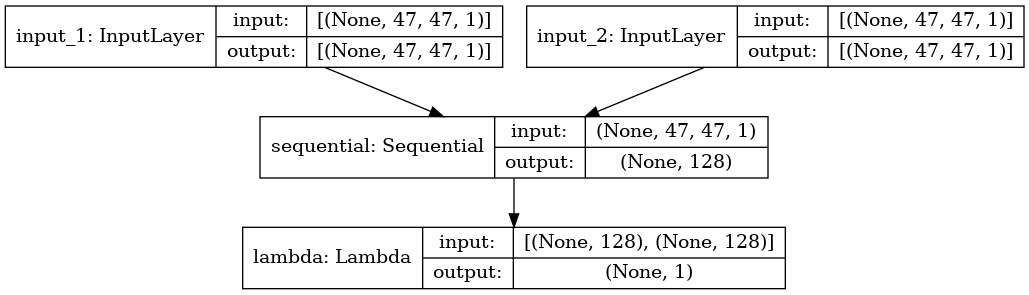

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [15]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded = encoder(faces.images.astype(float)).numpy()

Epoch 1/10
38/38 - 6s - loss: 0.0911 - accuracy: 0.7418 - val_loss: 0.0542 - val_accuracy: 0.8792
Epoch 2/10
38/38 - 5s - loss: 0.0360 - accuracy: 0.9383 - val_loss: 0.0378 - val_accuracy: 0.9229
Epoch 3/10
38/38 - 5s - loss: 0.0216 - accuracy: 0.9794 - val_loss: 0.0278 - val_accuracy: 0.9625
Epoch 4/10
38/38 - 5s - loss: 0.0167 - accuracy: 0.9852 - val_loss: 0.0237 - val_accuracy: 0.9688
Epoch 5/10
38/38 - 5s - loss: 0.0111 - accuracy: 0.9984 - val_loss: 0.0202 - val_accuracy: 0.9719
Epoch 6/10
38/38 - 5s - loss: 0.0085 - accuracy: 0.9992 - val_loss: 0.0189 - val_accuracy: 0.9781
Epoch 7/10
38/38 - 4s - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.0166 - val_accuracy: 0.9812
Epoch 8/10
38/38 - 5s - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0163 - val_accuracy: 0.9844
Epoch 9/10
38/38 - 5s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0140 - val_accuracy: 0.9875
Epoch 10/10
38/38 - 6s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9875
Accuracy on the tes

## IV. Classification in typical biometrics setting

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute pair-wise matching scores
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. 

In [16]:
def NormalizeData(data):
    return (np.max(data) - data) / (np.max(data) - np.min(data))

def construct_similarity_tensor(embedded, labels, dist_func, exclude_img_duplicates=True):
    #dist_func is the function that computes the distance between two images
    data = []
    n_samples = embedded.shape[0]
    for i,j in product(range(n_samples), range(n_samples)):
        # if comparing the same image
        if exclude_img_duplicates and i == j:
            continue
        data.append([
            labels[i], labels[j],
            dist_func(embedded[i], embedded[j])])
    return pd.DataFrame(data, columns=['s1', 's2', 'd'])

face_df = construct_similarity_tensor(embedded, targets, distance.euclidean)
normalized_face_vector = NormalizeData(face_df['d'].values) 

normalized_face_df = face_df.copy()
normalized_face_df['d'] = normalized_face_vector
face_mat = normalized_face_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.average)

genuine_df = normalized_face_df[normalized_face_df.apply(lambda x: x.s1 == x.s2, axis=1)]
impostor_df = normalized_face_df[normalized_face_df.apply(lambda x: x.s1 != x.s2, axis=1)]

genuine_scores = genuine_df['d'].values
impostor_scores = impostor_df['d'].values

total_scores = np.concatenate([genuine_scores, impostor_scores])
genuine_id = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])

print("Number of genuine scores:", genuine_scores.shape)
print("Number of impostor scores:", impostor_scores.shape)
print("Total scores:", total_scores.shape)
print("Genuine id scores", genuine_id.shape)

Number of genuine scores: (8420,)
Number of impostor scores: (184740,)
Total scores: (193160,)
Genuine id scores (193160,)


## V. Advanced classification scenario
Biometrics classification is based on generating pairwise matching scores. 
* In verification mode one compares this matching score to a decision threshold in a 1-to-1 classification setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N classification setting

Hence, a simple pairwise comparision (L2-distance, e.g.) can be used. 

In a more general classification scenario one can use the feature representations to build more complex classifiers (SVM, NN, etc.). Testing then requires a splitting in training and validation subsets. 

Here you find an example with KNN as classifiers and their validation results. 

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Holdout on dataset
X_train_class, X_test_class, y_train_class, y_test_class = holdout_split(embedded, faces.target)

### KNN classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train_class, y_train_class)

acc_knn = accuracy_score(y_test_class, knn.predict(X_test_class))
print(f'KNN accuracy = {acc_knn}')

KNN accuracy = 0.990909090909091


## VI. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments

### 1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature)

Face rec system -> Threshold for which F1 is maximal: 0.8775510204081632
Face rec system -> Max F1 score: 0.8997276553602377
Face rec system -> Threshold for which accuracy is maximal: 0.8775510204081632
Face rec system -> Max accuracy score: 0.9916131704286602


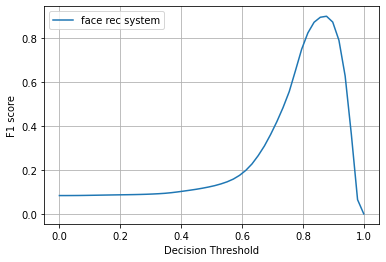

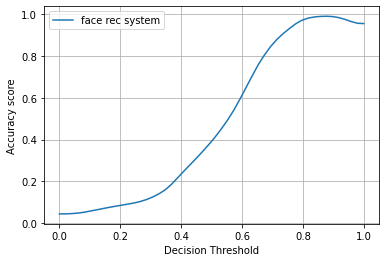

In [19]:
#"Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice
def plot_f1_score(total_scores, genuine_id, threshold_values):
    

    f1_score_array = []

    for threshold_value in threshold_values: 
        predicted_scores = np.array(total_scores > threshold_value).astype('int')
        f1_score_el = f1_score(genuine_id, predicted_scores)
        f1_score_array.append(f1_score_el)
    plt.figure()
    plt.plot(threshold_values, f1_score_array, label='face rec system')
    plt.xlabel('Decision Threshold')
    plt.ylabel('F1 score')
    plt.grid()
    plt.legend()

    idx_max = np.argmax(f1_score_array)
    threshold_value_maximize_f1 = threshold_values[idx_max]
    print("Face rec system -> Threshold for which F1 is maximal:",threshold_value_maximize_f1)
    print("Face rec system -> Max F1 score:", f1_score_array[idx_max])


def plot_accuracy_score(total_scores, genuine_id, threshold_values):
    """Do the same for the classification error (or accuracy)"""
    accuracy_score_array = []
    for threshold_value in threshold_values: 
        predicted_scores = np.array(total_scores > threshold_value).astype('int')
        accuracy_score_el = accuracy_score(genuine_id, predicted_scores)
        accuracy_score_array.append(accuracy_score_el)
    
    plt.figure()
    plt.plot(threshold_values, accuracy_score_array, label='face rec system')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Accuracy score')

    #plt.xticks(np.arange(0, 1, step=0.04))
    plt.grid()
    plt.legend()

    idx_max = np.argmax(accuracy_score_array)
    threshold_value_maximize_accuracy = threshold_values[idx_max]
    print("Face rec system -> Threshold for which accuracy is maximal:",threshold_value_maximize_accuracy)
    print("Face rec system -> Max accuracy score:", accuracy_score_array[idx_max])
    
threshold_values = np.linspace(0, 1, 50)
plot_f1_score(total_scores, genuine_id, threshold_values)
plot_accuracy_score(total_scores, genuine_id, threshold_values)

<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>


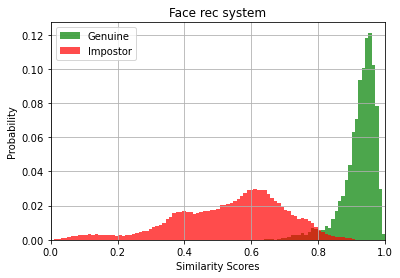

In [20]:
#Plot for face recognition system
def plot_histogram(genuine_scores, impostor_scores, bins):
    plt.figure()
    weights_genuine = np.ones_like(genuine_scores) / len(genuine_scores)
    plt.hist(genuine_scores, weights=weights_genuine, label='Genuine',
             bins=bins, alpha=0.7, color='g')

    weights_impostor = np.ones_like(impostor_scores) / len(impostor_scores)
    plt.hist(impostor_scores, weights=weights_impostor,label='Impostor',
             bins=bins, alpha=0.7, color='r')
    plt.title('Face rec system')
    #plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.xlabel('Similarity Scores')
    plt.ylabel('Probability')
    plt.grid()
    plt.xlim(0,1)
    plt.legend()
    plt.show()

bins = np.linspace(0, 1, 100)
plot_histogram(genuine_scores, impostor_scores, bins)

<div class="alert alert-block alert-success">
<b>Q4: </b> Calculate Equal Error Rate
</div>

intersection point [0.03270064] [0.03270064]
Face rec system-> Average precision scores: 0.9595686789839217


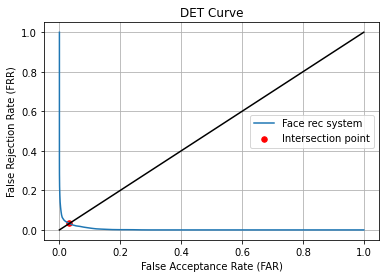

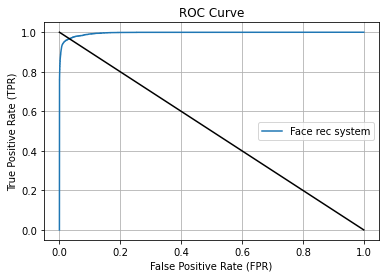

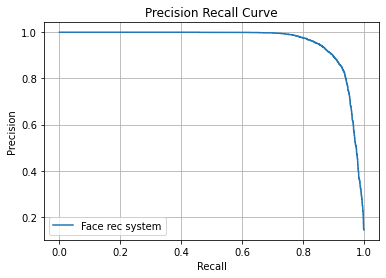

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def calculate_FAR(threshold, impostor_scores):
    impostor_scores_greater_threshold = impostor_scores[impostor_scores > threshold]
    FAR = len(impostor_scores_greater_threshold) / len(impostor_scores)
    return FAR

def calculate_FRR(threshold, genuine_scores):
    genuine_scores_lower_threshold = genuine_scores[genuine_scores < threshold]
    FRR = len(genuine_scores_lower_threshold) / len(genuine_scores)
    return FRR

def plot_det_curve(genuine_scores, impostor_scores, bins):
    
    FAR_array = []
    FRR_array = []

    for ii in bins:
        FAR_array.append(calculate_FAR(ii, impostor_scores))
        FRR_array.append(calculate_FRR(ii, genuine_scores))


    x, y = intersection(np.linspace(0,1,200),np.linspace(0,1,200), FAR_array, FRR_array)
    print("intersection point",x, y)
    plt.figure()
    plt.scatter(x, y, c='r', s=30, label='Intersection point')

    plt.plot(FAR_array, FRR_array, label='Face rec system')
    plt.plot(np.linspace(0,1,200),np.linspace(0,1,200), color='black')
    plt.xlabel('False Acceptance Rate (FAR)')
    plt.ylabel('False Rejection Rate (FRR)')
    plt.title('DET Curve')
    plt.legend()
    plt.grid()

def plot_roc_curve(genuine_id, total_scores):
    plt.figure()
    fpr, tpr, thresholds = roc_curve(genuine_id, total_scores, pos_label=1)
    plt.plot(fpr, tpr, label='Face rec system')

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.plot(np.linspace(0,1,200),np.linspace(1,0,200), color='black')
    #plt.xticks(np.arange(0, 1, step=0.04))
    #plt.yticks(np.arange(0, 1, step=0.04))
    plt.legend()
    plt.grid()

def plot_precision_recall_curve(genuine_id, total_scores):    
    plt.figure()
    precision, recall, thresholds_pr = precision_recall_curve(genuine_id, total_scores)
    plt.plot(recall, precision, label='Face rec system')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.grid()
    plt.legend()
    avg_precision_scores = np.average(precision)
    print('Face rec system-> Average precision scores:', average_precision_score(genuine_id, total_scores))

plot_det_curve(genuine_scores, impostor_scores, bins)
plot_roc_curve(genuine_id, total_scores)
plot_precision_recall_curve(genuine_id, total_scores)

<div class="alert alert-block alert-success">
<b>Q5: </b> Calculate classification scores
</div>

In [22]:
"""Calculate the ROC AUC."""
face_roc_auc_score = roc_auc_score(genuine_id, total_scores)
print('Face rec system ROC AUC score:', face_roc_auc_score)

Face rec system ROC AUC score: 0.9961769818634496


### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q6: </b> Generate a Cumulative Matching Curve
</div>

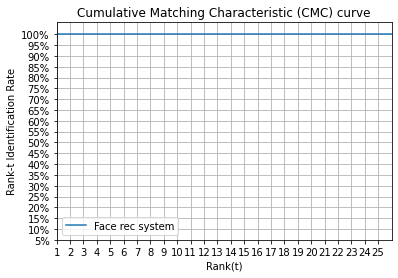

In [23]:
def plot_cmc_curve(df):
    
    """Calculate the Cumulative Matching Characteristic curve."""
    
    rank_identification_rate_array = []
    rank_identification_rate_array = []
    length = df.shape[0]
    
    for ii in range(1, length + 1):
        similarity_matrix_copy = df.copy()
        similarity_matrix_copy_largest = similarity_matrix_copy.apply(pd.Series.nlargest, axis=0, n=ii).reindex(similarity_matrix_copy.columns)
        rank_identification_rate = sum(~np.isnan(np.diagonal(similarity_matrix_copy_largest.values))) / similarity_matrix_copy_largest.shape[0]
        rank_identification_rate_array.append(rank_identification_rate)

    plt.figure()
    plt.plot(np.arange(1, length + 1), rank_identification_rate_array, label='Face rec system')
    plt.title('Cumulative Matching Characteristic (CMC) curve')
    plt.xlabel('Rank(t)')
    plt.ylabel('Rank-t Identification Rate')
    plt.xticks(np.arange(1, length))
    plt.xlim(1, length)
    plt.yticks(np.arange(0.05, 1.05, 0.05))
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid()
    plt.show()
    
plot_cmc_curve(face_mat)

### 3. Validation in multi-classification setting
<div class="alert alert-block alert-success">
<b>Q7: </b> Validate the advanced classification scenario
You can choose an appropriate metric.
</div>

## VII. Task
All tasks should be accompanied by a text providing information on; the technique, the steps, and, the reasoning behind choosing the techniques.

<em>Note: in case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. </em>

### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics and report on the performance.

### 2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW) (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. (1pt.)
3. Develop a new advanced classifier (beyond KNN) and compare the results with the current KNN classifier. (1pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and compare the results. (1pt.) 
6. Implement a different deep learning model* (2pt.)

e.g. performing task 6 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters, activation functions does not count.

## 1. Evaluate your system on the other two datasets (AT&T, LFW) (1pt.)

### 1.1 AT&T Dataset

In [24]:
from sklearn.datasets import fetch_olivetti_faces

olivetti_faces = fetch_olivetti_faces() # download the dataset at ~/scikit_learn_data
print("Keys:", olivetti_faces.keys()) # display keys
print("Total samples and image size:", np.expand_dims(olivetti_faces.images, axis=-1).shape)
print("Total samples and features:", olivetti_faces.data.shape)
print("Total samples and targets:", olivetti_faces.target.shape)
olivetti_faces.images = np.expand_dims(olivetti_faces.images, axis=-1)
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = olivetti_faces.images.shape
olivetti_imshape = (h, w, n_channels)

# count number of individuals
n_classes = olivetti_faces.target.max() +1

n_features = olivetti_faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

olivetti_num_components=100

if DESC == FeatureDescriptor.PCA:
    olivetti_pca_componenets = 35# Compute a PCA (eigenfaces) on the face dataset
    num_components = min(olivetti_pca_componenets, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    olivetti_desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(olivetti_faces.data)
    olivetti_X_pca = olivetti_desc.transform(olivetti_faces.data)
    olivetti_embedded = olivetti_X_pca
    
if DESC == FeatureDescriptor.LBP:
    olivetti_desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    olivetti_embedded = desc.describe_list(olivetti_faces.images[...,0])
    
    dist_metric = chisquare
    
if DESC == FeatureDescriptor.LDA:
    num_components = min(olivetti_num_components, min(n_classes-1, n_features))
    print('num_components:', num_components)
    olivetti_desc = LinearDiscriminantAnalysis(n_components=num_components).fit(olivetti_faces.data, olivetti_faces.target)
    olivetti_X_lda = olivetti_desc.fit_transform(olivetti_faces.data, olivetti_faces.target)
    olivetti_embedded = olivetti_X_lda
    dist_metric = euclidean

if DESC == FeatureDescriptor.DL:
    olivetti_encoder, olivetti_model = siamese.create_siamese_model(olivetti_imshape)
    olivetti_model.summary()
    olivetti_x_train, olivetti_x_test, olivetti_y_train, olivetti_y_test = holdout_split(*siamese.get_siamese_paired_data(olivetti_faces.images,
                                                                                                                          olivetti_faces.target))
    rms = Adam()
    olivetti_model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])

    epochs = 20
    olivetti_model.fit([olivetti_x_train[:, 0], olivetti_x_train[:, 1]], olivetti_y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    olivetti_test_scores = olivetti_model.predict([olivetti_x_test[:, 0], olivetti_x_test[:, 1]])
    olivetti_test_acc = accuracy_score(olivetti_y_test, olivetti_test_scores > 0.5)
    print("Accuracy on the test set: {}".format(olivetti_test_acc))
    olivetti_embedded = olivetti_encoder(np.expand_dims(olivetti_faces.images, axis=-1).astype(float)).numpy()

Keys: dict_keys(['data', 'images', 'target', 'DESCR'])
Total samples and image size: (400, 64, 64, 1)
Total samples and features: (400, 4096)
Total samples and targets: (400,)
Total dataset size:
n_samples: 400
n_classes: 40
n_features: 4096
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          1680832     input_3[0][0]                    
                                                

Number of genuine scores: (3600,)
Number of impostor scores: (156000,)
Total scores: (159600,)
Genuine id scores (159600,)


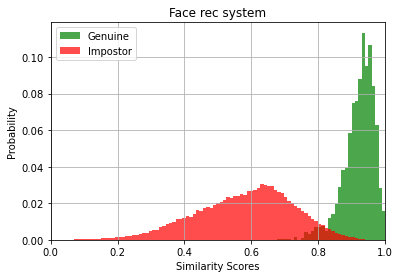

intersection point [0.0372] [0.0372]


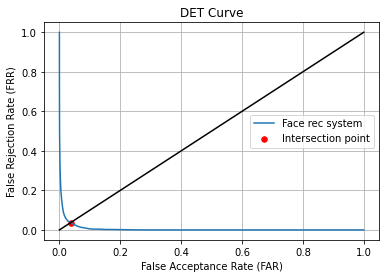

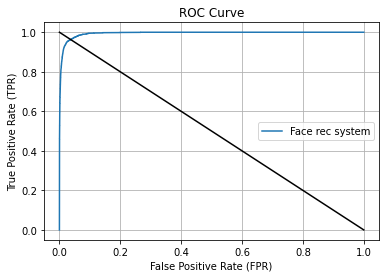

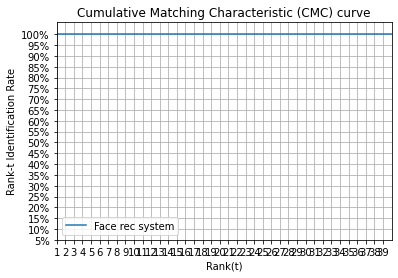

Face rec system -> Threshold for which F1 is maximal: 0.8979591836734693
Face rec system -> Max F1 score: 0.7916910473961382
Face rec system -> Threshold for which accuracy is maximal: 0.8979591836734693
Face rec system -> Max accuracy score: 0.991077694235589
Face rec system ROC AUC score: 0.9945944017094017


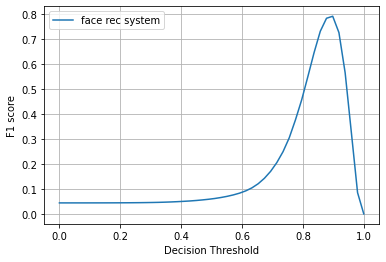

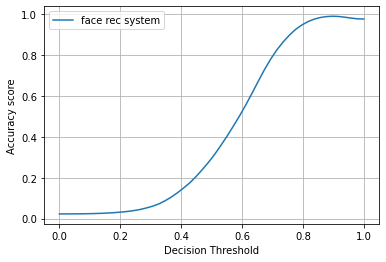

In [25]:
olivetti_face_df = construct_similarity_tensor(olivetti_embedded, olivetti_faces.target, distance.euclidean)
olivetti_normalized_face_vector = NormalizeData(olivetti_face_df['d'].values) 

olivetti_normalized_face_df = olivetti_face_df.copy()
olivetti_normalized_face_df['d'] = olivetti_normalized_face_vector
olivetti_face_mat = olivetti_normalized_face_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.average)

olivetti_genuine_df = olivetti_normalized_face_df[olivetti_normalized_face_df.apply(lambda x: x.s1 == x.s2, axis=1)]
olivetti_impostor_df = olivetti_normalized_face_df[olivetti_normalized_face_df.apply(lambda x: x.s1 != x.s2, axis=1)]

olivetti_genuine_scores = olivetti_genuine_df['d'].values
olivetti_impostor_scores = olivetti_impostor_df['d'].values

olivetti_total_scores = np.concatenate([olivetti_genuine_scores, olivetti_impostor_scores])
olivetti_genuine_id = np.concatenate([np.ones_like(olivetti_genuine_scores), np.zeros_like(olivetti_impostor_scores)])

print("Number of genuine scores:", olivetti_genuine_scores.shape)
print("Number of impostor scores:", olivetti_impostor_scores.shape)
print("Total scores:", olivetti_total_scores.shape)
print("Genuine id scores", olivetti_genuine_id.shape)

plot_histogram(olivetti_genuine_scores, olivetti_impostor_scores, bins)
plot_det_curve(olivetti_genuine_scores, olivetti_impostor_scores, bins)
plot_roc_curve(olivetti_genuine_id, olivetti_total_scores)
plot_cmc_curve(olivetti_face_mat)
plot_f1_score(olivetti_total_scores, olivetti_genuine_id, threshold_values)
plot_accuracy_score(olivetti_total_scores, olivetti_genuine_id, threshold_values)

olivetti_roc_auc_score = roc_auc_score(olivetti_genuine_id, olivetti_total_scores)
print('Face rec system ROC AUC score:', olivetti_roc_auc_score)

### 1.2 LFW Dataset

In [2]:
from sklearn.datasets import fetch_lfw_people

lfw_faces = fetch_lfw_people(min_faces_per_person=40) # download the dataset at ~/scikit_learn_data
print("Keys:", lfw_faces.keys()) # display keys
lfw_faces.images = np.array([cv2.resize(lfw_faces.images[ii], (lfw_faces.images[ii].shape[1], lfw_faces.images[ii].shape[1])) for ii in range(lfw_faces.images.shape[0])])
lfw_faces.data = lfw_faces.images.reshape(-1, lfw_faces.images.shape[1] * lfw_faces.images.shape[2])
print("Total samples and image size:", np.expand_dims(lfw_faces.images, axis=-1).shape)
print("Total samples and features:", lfw_faces.data.shape)
print("Total samples and targets:", lfw_faces.target.shape)
lfw_faces.images = np.expand_dims(lfw_faces.images, axis=-1)
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = lfw_faces.images.shape
lfw_imshape = (h, w, n_channels)

#count number of individuals
n_classes = lfw_faces.target.max() +1

n_features = lfw_faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

lfw_num_components=1000

if DESC == FeatureDescriptor.PCA:
    lfw_pca_componenets = 35# Compute a PCA (eigenfaces) on the face dataset
    num_components = min(lfw_pca_componenets, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    lfw_desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(lfw_faces.data)
    lfw_X_pca = lfw_desc.transform(lfw_faces.data)
    lfw_embedded = lfw_X_pca
    
if DESC == FeatureDescriptor.LBP:
    lfw_desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    lfw_embedded = lfw_desc.describe_list(lfw_faces.images[...,0])
    
    dist_metric = chisquare
    
if DESC == FeatureDescriptor.LDA:
    lfw_num_components = min(lfw_num_components, min(n_classes-1, n_features))
    print('num_components:', lfw_num_components)
    lfw_desc = LinearDiscriminantAnalysis(n_components=lfw_num_components).fit(lfw_faces.data, lfw_faces.target)
    lfw_X_lda = lfw_desc.fit_transform(lfw_faces.data, lfw_faces.target)
    lfw_embedded = lfw_X_lda
    dist_metric = euclidean

if DESC == FeatureDescriptor.DL:
    lfw_encoder, lfw_model = siamese.create_siamese_model(lfw_imshape)
    lfw_model.summary()
    lfw_x_train, lfw_x_test, lfw_y_train, lfw_y_test = holdout_split(*siamese.get_siamese_paired_data(lfw_faces.images, lfw_faces.target))
    rms = Adam()
    lfw_model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])

    epochs = 20
    lfw_model.fit([lfw_x_train[:, 0], lfw_x_train[:, 1]], lfw_y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    lfw_test_scores = lfw_model.predict([lfw_x_test[:, 0], lfw_x_test[:, 1]])
    lfw_test_acc = accuracy_score(lfw_y_test, lfw_test_scores > 0.5)
    print("Accuracy on the test set: {}".format(lfw_test_acc))
    lfw_embedded = lfw_encoder(np.expand_dims(lfw_faces.images, axis=-1).astype(float)).numpy()

Keys: dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])


NameError: name 'np' is not defined

Number of genuine scores: (421330,)
Number of impostor scores: (3062492,)
Total scores: (3483822,)
Genuine id scores (3483822,)


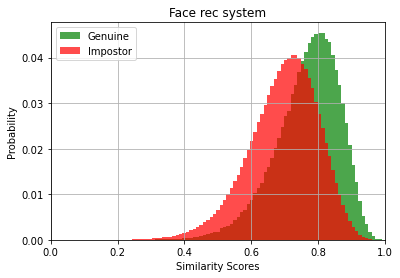

intersection point [0.35090115] [0.35090115]


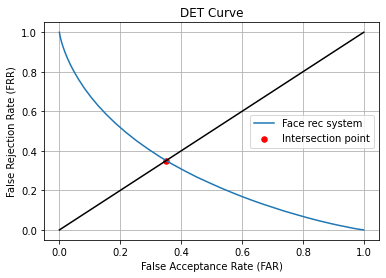

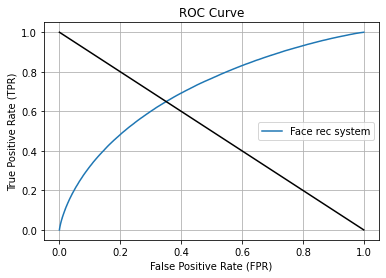

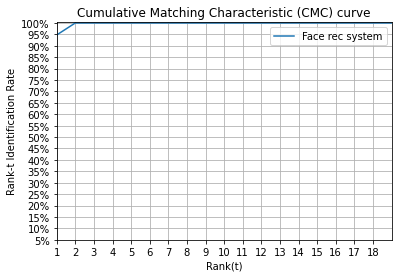

Face rec system -> Threshold for which F1 is maximal: 0.7959183673469387
Face rec system -> Max F1 score: 0.3287371327776331
Face rec system -> Threshold for which accuracy is maximal: 0.9183673469387754
Face rec system -> Max accuracy score: 0.8795070471453479
Face rec system ROC AUC score: 0.70291078100239


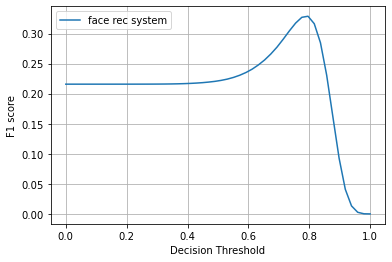

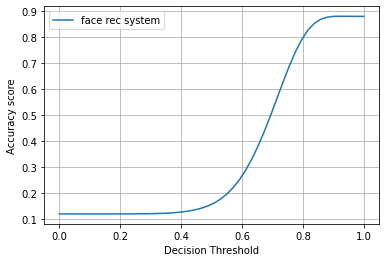

In [27]:
lfw_face_df = construct_similarity_tensor(lfw_embedded, lfw_faces.target, distance.euclidean)
lfw_normalized_face_vector = NormalizeData(lfw_face_df['d'].values) 

lfw_normalized_face_df = lfw_face_df.copy()
lfw_normalized_face_df['d'] = lfw_normalized_face_vector
lfw_face_mat = lfw_normalized_face_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.average)

lfw_genuine_df = lfw_normalized_face_df[lfw_normalized_face_df.apply(lambda x: x.s1 == x.s2, axis=1)]
lfw_impostor_df = lfw_normalized_face_df[lfw_normalized_face_df.apply(lambda x: x.s1 != x.s2, axis=1)]

lfw_genuine_scores = lfw_genuine_df['d'].values
lfw_impostor_scores = lfw_impostor_df['d'].values

lfw_total_scores = np.concatenate([lfw_genuine_scores, lfw_impostor_scores])
lfw_genuine_id = np.concatenate([np.ones_like(lfw_genuine_scores), np.zeros_like(lfw_impostor_scores)])

print("Number of genuine scores:", lfw_genuine_scores.shape)
print("Number of impostor scores:", lfw_impostor_scores.shape)
print("Total scores:", lfw_total_scores.shape)
print("Genuine id scores", lfw_genuine_id.shape)

plot_histogram(lfw_genuine_scores, lfw_impostor_scores, bins)
plot_det_curve(lfw_genuine_scores, lfw_impostor_scores, bins)
plot_roc_curve(lfw_genuine_id, lfw_total_scores)
plot_cmc_curve(lfw_face_mat)
plot_f1_score(lfw_total_scores, lfw_genuine_id, threshold_values)
plot_accuracy_score(lfw_total_scores, lfw_genuine_id, threshold_values)

lfw_roc_auc_score = roc_auc_score(lfw_genuine_id, lfw_total_scores)
print('Face rec system ROC AUC score:', lfw_roc_auc_score)

Face rec system-> Average precision scores: 0.8764125769241371


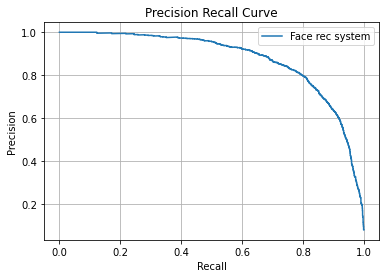

In [28]:
plot_precision_recall_curve( olivetti_genuine_id, olivetti_total_scores)

## 3. Develop a new advanced classifier (beyond KNN) and compare the results with the current KNN classifier. (1pt.)

In [440]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
#svc = LinearSVC()
X_train_class, X_test_class, y_train_class, y_test_class = holdout_split(olivetti_embedded, olivetti_faces.target)
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
svc = GridSearchCV(SVC(), param_grid, cv=3)
svc.fit(X_train_class, y_train_class)
acc_svc = accuracy_score(y_test_class, svc.predict(X_test_class))
print('SVM - accuracy = {}'.format(acc_svc))

SVM - accuracy = 1.0


## 5. Pre-train your deep learning network on a different (larger) dataset and compare the results. (1pt.)

### 5.1 Without fine tuning

Keys: dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
Total samples and image size: (13233, 47, 47, 1)
Total samples and features: (13233, 2209)
Total samples and targets: (13233,)
Total dataset size:
n_samples: 13233
n_classes: 5749
n_features: 2209
Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_142 (InputLayer)          [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential_70 (Sequential)      (None, 128)          894400      input_141[0][0]                  
                     

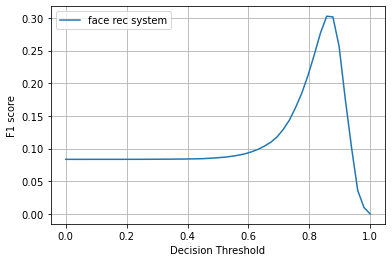

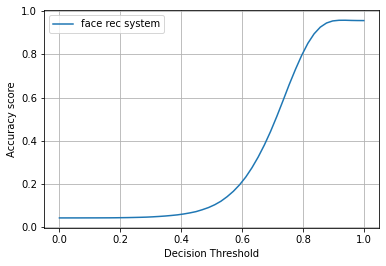

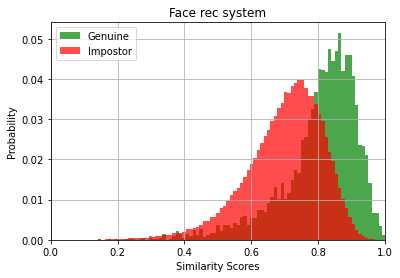

intersection point [0.28452374] [0.28452374]
Face rec system-> Average precision scores: 0.25926505171940767


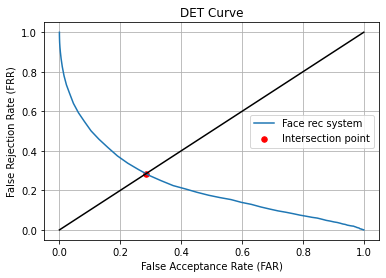

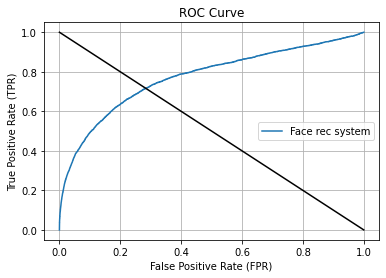

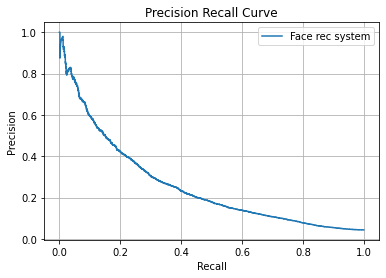

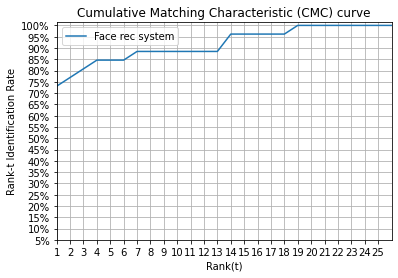

In [441]:
from sklearn.datasets import fetch_lfw_people

lfw_faces = fetch_lfw_people() # download the dataset at ~/scikit_learn_data
print("Keys:", lfw_faces.keys()) # display keys
lfw_faces.images = np.array([cv2.resize(lfw_faces.images[ii], (lfw_faces.images[ii].shape[1], lfw_faces.images[ii].shape[1])) for ii in range(lfw_faces.images.shape[0])])
lfw_faces.data = lfw_faces.images.reshape(-1, lfw_faces.images.shape[1] * lfw_faces.images.shape[2])
print("Total samples and image size:", np.expand_dims(lfw_faces.images, axis=-1).shape)
print("Total samples and features:", lfw_faces.data.shape)
print("Total samples and targets:", lfw_faces.target.shape)
n_samples, h, w, n_channels = np.expand_dims(lfw_faces.images, axis=-1).shape
lfw_imshape = (h, w, n_channels)
n_classes = lfw_faces.target.max() +1
n_features = lfw_faces.data.shape[1]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)
lfw_encoder, lfw_model = siamese.create_siamese_model(lfw_imshape)
lfw_model.summary()
lfw_x_train, lfw_x_test, lfw_y_train, lfw_y_test = holdout_split(*siamese.get_siamese_paired_data(np.expand_dims(lfw_faces.images, axis=-1),
                                                                                  lfw_faces.target))
rms = Adam()
lfw_model.compile(
    loss=siamese.contrastive_loss, 
    optimizer=rms, 
    metrics = [siamese.accuracy])

epochs = 30
lfw_model.fit([lfw_x_train[:, 0], lfw_x_train[:, 1]], lfw_y_train, 
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs)

lfw_test_scores = lfw_model.predict([lfw_x_test[:, 0], lfw_x_test[:, 1]])
lfw_test_acc = accuracy_score(lfw_y_test, lfw_test_scores > 0.5)
print("Accuracy on the test set: {}".format(lfw_test_acc))

embedded = lfw_encoder(faces.images.astype(float)).numpy()
    
face_df = construct_similarity_tensor(embedded, targets, distance.euclidean)
normalized_face_vector = NormalizeData(face_df['d'].values) 

normalized_face_df = face_df.copy()
normalized_face_df['d'] = normalized_face_vector
face_mat = normalized_face_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.average)

genuine_df = normalized_face_df[normalized_face_df.apply(lambda x: x.s1 == x.s2, axis=1)]
impostor_df = normalized_face_df[normalized_face_df.apply(lambda x: x.s1 != x.s2, axis=1)]

genuine_scores = genuine_df['d'].values
impostor_scores = impostor_df['d'].values

total_scores = np.concatenate([genuine_scores, impostor_scores])
genuine_id = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])

threshold_values = np.linspace(0, 1, 50)
plot_f1_score(total_scores, genuine_id, threshold_values)
plot_accuracy_score(total_scores, genuine_id, threshold_values)

bins = np.linspace(0, 1, 100)
plot_histogram(genuine_scores, impostor_scores, bins)
plot_det_curve(genuine_scores, impostor_scores, bins)
plot_roc_curve(genuine_id, total_scores)
plot_precision_recall_curve(genuine_id, total_scores)
face_roc_auc_score = roc_auc_score(genuine_id, total_scores)
plot_cmc_curve(face_mat)
lfw_model.save_weights('lfw_model_weights.h5')

### 5.2 With fine tuning

Epoch 1/20
38/38 - 6s - loss: 0.0718 - accuracy: 0.8331 - val_loss: 0.0404 - val_accuracy: 0.9010
Epoch 2/20
38/38 - 5s - loss: 0.0288 - accuracy: 0.9613 - val_loss: 0.0272 - val_accuracy: 0.9521
Epoch 3/20
38/38 - 6s - loss: 0.0185 - accuracy: 0.9836 - val_loss: 0.0209 - val_accuracy: 0.9792
Epoch 4/20
38/38 - 6s - loss: 0.0119 - accuracy: 0.9926 - val_loss: 0.0176 - val_accuracy: 0.9792
Epoch 5/20
38/38 - 6s - loss: 0.0086 - accuracy: 0.9967 - val_loss: 0.0159 - val_accuracy: 0.9823
Epoch 6/20
38/38 - 6s - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.0142 - val_accuracy: 0.9823
Epoch 7/20
38/38 - 6s - loss: 0.0055 - accuracy: 0.9992 - val_loss: 0.0130 - val_accuracy: 0.9823
Epoch 8/20
38/38 - 6s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0127 - val_accuracy: 0.9823
Epoch 9/20
38/38 - 5s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9823
Epoch 10/20
38/38 - 6s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9823
Epoch 11/20
38/38 -

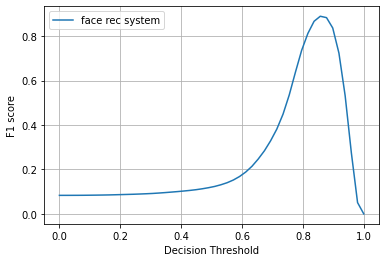

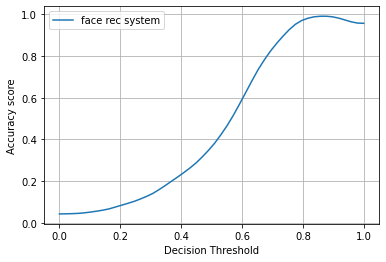

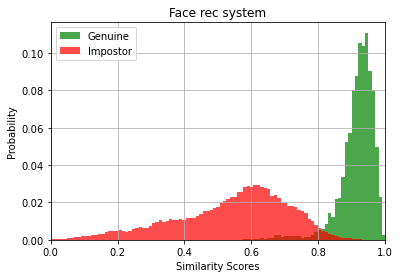

intersection point [0.0311857] [0.0311857]
Face rec system-> Average precision scores: 0.9464283042875123


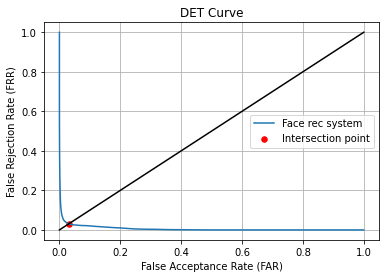

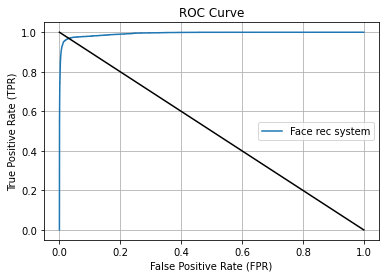

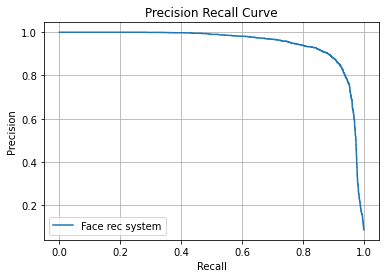

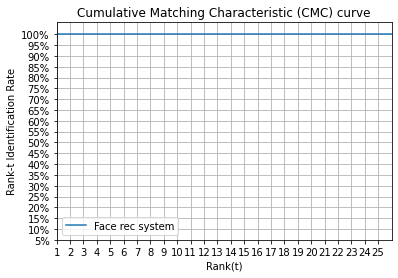

In [444]:
pretrained_encoder, pretrained_model = siamese.create_siamese_model(imshape)
pretrained_model.load_weights('lfw_model_weights.h5')
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))

pretrained_model.compile(
    loss=siamese.contrastive_loss, 
    optimizer=rms, 
    metrics = [siamese.accuracy])

epochs = 20
pretrained_model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs)

test_scores = pretrained_model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
pretrained_embedded = pretrained_encoder(faces.images.astype(float)).numpy()
print(pretrained_embedded.shape)

face_df = construct_similarity_tensor(pretrained_embedded, targets, distance.euclidean)
normalized_face_vector = NormalizeData(face_df['d'].values) 

normalized_face_df = face_df.copy()
normalized_face_df['d'] = normalized_face_vector
face_mat = normalized_face_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.average)

genuine_df = normalized_face_df[normalized_face_df.apply(lambda x: x.s1 == x.s2, axis=1)]
impostor_df = normalized_face_df[normalized_face_df.apply(lambda x: x.s1 != x.s2, axis=1)]

genuine_scores = genuine_df['d'].values
impostor_scores = impostor_df['d'].values

total_scores = np.concatenate([genuine_scores, impostor_scores])
genuine_id = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])

threshold_values = np.linspace(0, 1, 50)
plot_f1_score(total_scores, genuine_id, threshold_values)
plot_accuracy_score(total_scores, genuine_id, threshold_values)

bins = np.linspace(0, 1, 100)
plot_histogram(genuine_scores, impostor_scores, bins)
plot_det_curve(genuine_scores, impostor_scores, bins)
plot_roc_curve(genuine_id, total_scores)
plot_precision_recall_curve(genuine_id, total_scores)
face_roc_auc_score = roc_auc_score(genuine_id, total_scores)
plot_cmc_curve(face_mat)

In [443]:
print(roc_auc_score(genuine_id, total_scores))

0.989762154013974
